# COMPER-V5 - EXPERIMENT RESULTS REPORT FOR BATTLE ZONE
## This notebook presents the results to COMPER-V5 training runs with this setup:

- Frames mode: staked (84x84x1)
- Total frames: 100,000
- Epsilon decay: from 1 to 0.001 at 90,000 frames
- Color average: yes
- Skip frames: 5
- Stick actions: 0.25

## OBS: Make this changes to each progress json on each trial folder:

- For each log line insert colunm "Trail":{number of the trial}
- Replace the fist lines NaN values in EpRewardsSum and AvgEpReturn to 0.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import seaborn as sns
from numpy import median
import numpy as np
%matplotlib inline

### LOAD DATA

#### Load all log files

In [2]:
df = pd.DataFrame()
for i in range(1,6):
  aux = pd.read_json('logs/comper_v5/single_frames/v5-battle_zone-'+str(i)+'/progress.json',lines=True)
  aux["Trial"] = i
  df=  df.append(aux)
df = df.set_index(["Trial"])
print(df.shape)

(1150, 15)


In [3]:
#Check number of episodes to define the avarages windows sizes
n_trials = len(df.reset_index()["Trial"].unique())
print(n_trials)
n_episodes = len(df["Episodes"].unique())
print(n_episodes)
LAST_EPISODES = 3 if n_episodes<25 else 5
LAST_EPISODES_PER_TRIAL = 3 if n_episodes<25 else 10
MOVING_AVG_WINDOWS_SIZE = 3 if n_episodes<25 else 10

5
22


#### Plot log informations 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1150 entries, 1 to 5
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Count              1150 non-null   int64  
 1   Rom                1150 non-null   object 
 2   Time               1150 non-null   object 
 3   Itr                1150 non-null   int64  
 4   EpFramesNumber     1150 non-null   int64  
 5   TMCount            1150 non-null   int64  
 6   RTMCount           1150 non-null   int64  
 7   Eps                1150 non-null   float64
 8   Episodes           1150 non-null   int64  
 9   EndEp              1150 non-null   bool   
 10  CurrEpRewardSum    1150 non-null   int64  
 11  EpRewardsSum       1150 non-null   int64  
 12  AvgEpReturn        1097 non-null   float64
 13  TDE                1145 non-null   float64
 14  TotalFramesNumber  1150 non-null   int64  
dtypes: bool(1), float64(3), int64(9), object(2)
memory usage: 135.9+ KB


## CHARTS

In [5]:
#Get only the final of each episod
df_1 = df.reset_index()
df_1 = df_1[(df_1["EndEp"] == True)]
df_1 = df_1.set_index(["Trial"])

#Calc the moving average over the episodes per trial
df_ma = df_1.loc[1]["CurrEpRewardSum"].rolling(window=MOVING_AVG_WINDOWS_SIZE).mean()#média móvel 
df_ma = df_ma.to_frame()
df_ma.dropna(inplace=True)
df_ma['Counter'] = range(len(df_ma))
for i in range(2,6):
    aux = df_1.loc[i]["CurrEpRewardSum"].rolling(window=MOVING_AVG_WINDOWS_SIZE).mean()   
    aux = aux.to_frame()    
    aux.dropna(inplace=True)    
    aux['Counter'] = range(len(aux))
    df_ma = df_ma.append(aux)


#Calc min. and max. reward per trial
min_max_mean = pd.DataFrame(index=['1', '2', '3', '4', '5'], columns=['min', 'max', 'mean'])
for i in range(0,5):
    min_max_mean.iloc[i]['min'] = df_1.loc[(i+1)]["CurrEpRewardSum"].min()
    min_max_mean.iloc[i]['max'] =  df_1.loc[(i+1)]["CurrEpRewardSum"].max()
    min_max_mean.iloc[i]['mean'] = df_1.loc[(i+1)]["CurrEpRewardSum"].mean()

#Calc each tertile scores average and the last episodes score average per tertile per trial
trials = df_1.reset_index()
trials_n = trials["Trial"].unique()
tirtle_avg = pd.DataFrame()
tritle_last_ep_avg = pd.DataFrame()
for i in trials_n:
    trial=trials.loc[trials['Trial'] == i]
    trial_rews = trial["CurrEpRewardSum"].to_numpy()
    tertiles = np.array_split(trial_rews,3)    
    tirtle_avg = tirtle_avg.append({"Trial":i,"Tirtle1":np.mean(tertiles[0]),"Tirtle2": np.mean(tertiles[1]),"Tirtle3":np.mean(tertiles[2])},ignore_index=True)
    tritle_last_ep_avg = tritle_last_ep_avg.append(
        {"Trial":i,
        "Tirtle1":np.mean(np.array(tertiles[0])[-LAST_EPISODES:]),
        "Tirtle2": np.mean(np.array(tertiles[1])[-LAST_EPISODES:]),
        "Tirtle3":np.mean(np.array(tertiles[2])[-LAST_EPISODES:])},ignore_index=True)
tirtle_avg = tirtle_avg.set_index(["Trial"])
tritle_last_ep_avg = tritle_last_ep_avg.set_index(["Trial"])

#Cal the average for the last episodes per trial
df_last_mean = pd.DataFrame(index=['1', '2', '3', '4', '5'],columns=['Mean'] )
for i in range (0,5):
    df_last_mean.iloc[i]['Mean'] = df_1.loc[i+1]["CurrEpRewardSum"][(-LAST_EPISODES_PER_TRIAL):].mean()

[Text(0.5, 0, 'Episodes'), Text(0, 0.5, 'Reward')]

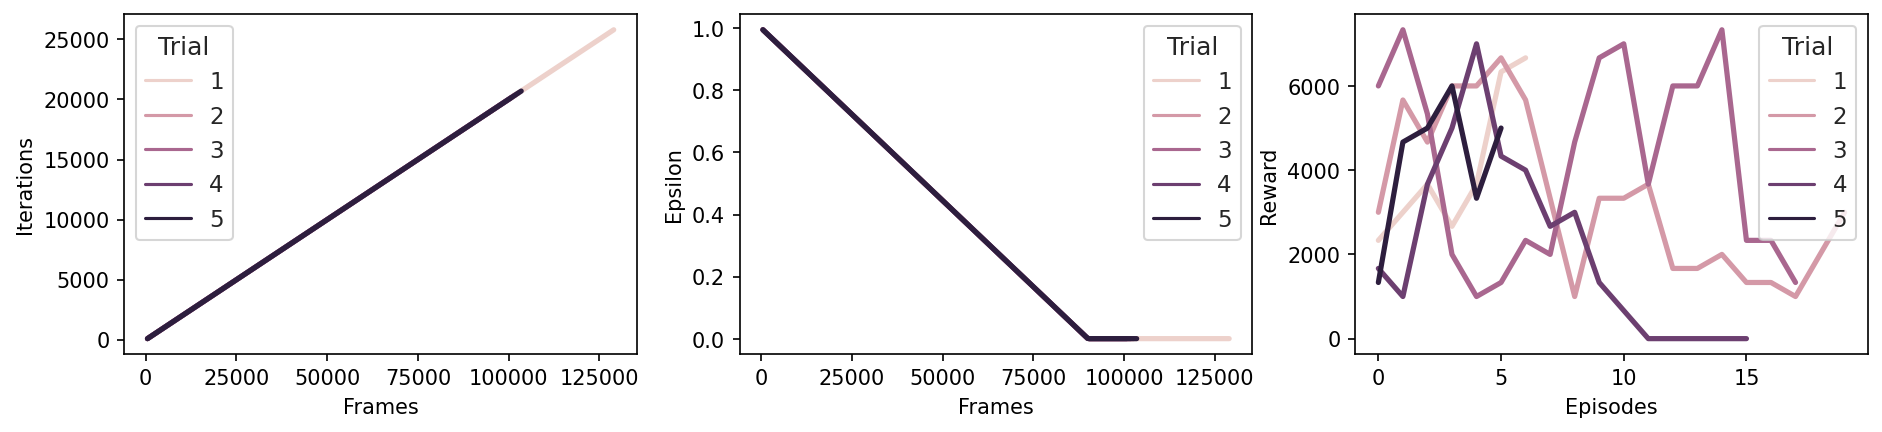

In [6]:
fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(15)
fig.set_figheight(3)
fig.set_dpi(150)
sns.set_theme(style="whitegrid")#, palette="pastel")
sns.lineplot(data=df, x="TotalFramesNumber", y="Itr", hue="Trial", linewidth=2.5,ax=axs[0]).set(xlabel="Frames", ylabel="Iterations")
sns.lineplot(data=df, x="TotalFramesNumber", y="Eps", hue="Trial", linewidth=2.5,ax=axs[1]).set(xlabel="Frames", ylabel="Epsilon")
sns.lineplot(data=df_ma, x="Counter", y="CurrEpRewardSum", hue="Trial", linewidth=2.5,ax=axs[2]).set(xlabel="Episodes", ylabel="Reward")


In [7]:
sns.set(font_scale=0.5)

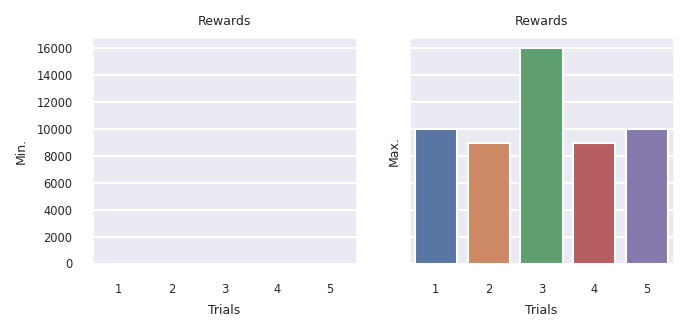

In [8]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
fig.set_figwidth(5)
fig.set_figheight(2)
fig.set_dpi(150)
g =sns.barplot(data=min_max_mean, x=min_max_mean.index ,y='min', ax=axs[0]).set(title= "Rewards",ylabel="Min.", xlabel = 'Trials')
g = sns.barplot(data=min_max_mean, x=min_max_mean.index ,y='max', ax=axs[1]).set(title= "Rewards",ylabel="Max.", xlabel = 'Trials')

[Text(0.5, 1.0, 'Last 3 Average Reward'), Text(0.5, 0, '5 Trials')]

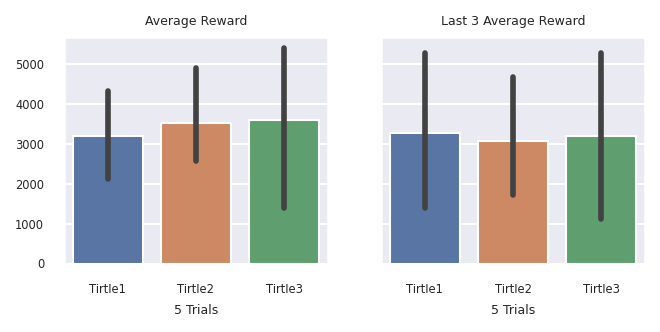

In [9]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
fig.set_figwidth(5)
fig.set_figheight(2)
fig.set_dpi(150)
sns.barplot(data=tirtle_avg,ax=axs[0]).set(title= "Average Reward", xlabel = '5 Trials')
sns.barplot(data=tritle_last_ep_avg,ax=axs[1]).set(title= 'Last ' +str(LAST_EPISODES)+' Average Reward', xlabel = '5 Trials')  

[Text(0.5, 1.0, 'Average 3 Episodes'),
 Text(0, 0.5, ''),
 Text(0.5, 0, 'Trials')]

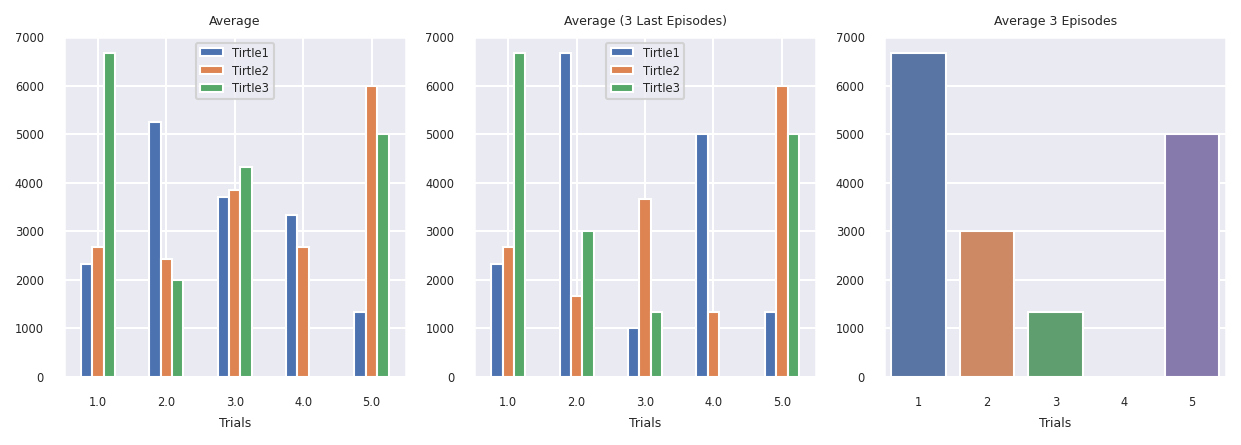

In [10]:
fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(10)
fig.set_figheight(3)
fig.set_dpi(150)
#fig.set_dpi(300)
tirtle_avg.plot(kind="bar",ax=axs[0],rot=0).set(title= 'Average', xlabel = 'Trials')
tritle_last_ep_avg.plot(kind="bar",ax = axs[1],rot=0).set(title= 'Average ('+str(LAST_EPISODES)+' Last Episodes)', xlabel = 'Trials')
sns.barplot(data=df_last_mean, x=df_last_mean.index,y='Mean',ax=axs[2]).set(title= 'Average ' +str(LAST_EPISODES_PER_TRIAL)+ ' Episodes',ylabel="", xlabel = 'Trials')

In [11]:
df_t = df_last_mean.transpose()
mean_ = np.mean(df_t[['1','2','3','4','5']].to_numpy())
std = np.std(df_t[['1','2','3','4','5']].to_numpy()).round(decimals=2)
df_t['mean'] = mean_
df_t['std'] = std
df_t

,1,2,3,4,5,mean,std
Mean,6666.666667,3000.0,1333.333333,0.0,5000.0,3200.0,2409.24


In [12]:
tritle_last_ep_avg
print(tritle_last_ep_avg)
df_t = pd.DataFrame(tritle_last_ep_avg)
print(pd.DataFrame(tritle_last_ep_avg.mean(axis=0)))
print(pd.DataFrame(tritle_last_ep_avg.std(axis=0)))

           Tirtle1      Tirtle2      Tirtle3
Trial                                       
1.0    2333.333333  2666.666667  6666.666667
2.0    6666.666667  1666.666667  3000.000000
3.0    1000.000000  3666.666667  1333.333333
4.0    5000.000000  1333.333333     0.000000
5.0    1333.333333  6000.000000  5000.000000
                   0
Tirtle1  3266.666667
Tirtle2  3066.666667
Tirtle3  3200.000000
                   0
Tirtle1  2465.314945
Tirtle2  1876.758435
Tirtle3  2693.613847
